<a href="https://colab.research.google.com/github/pratikiiitb2013/ERA/blob/main/S10/S10_practice2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -U albumentations
%pip install -U torch_lr_finder

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 1.8 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%cd /content/gdrive/My\ Drive/Colab\ Notebooks/ERAV1/S10/

/content/gdrive/My Drive/Colab Notebooks/ERAV1/S10


In [4]:
!ls -l

total 30
-rw------- 1 root root  3065 Aug  4 13:10 custom_resnet.py
drwx------ 2 root root  4096 Aug  4 12:57 data
-rw------- 1 root root  1440 Aug  4 13:10 data_aug.py
-rw------- 1 root root  1229 Aug  4 13:10 data_loaders.py
drwx------ 2 root root  4096 Aug  4 12:55 __pycache__
-rw------- 1 root root 12611 Aug  4 13:38 S10_practice2.ipynb
-rw------- 1 root root  2458 Aug  4 13:10 train_test.py
-rw------- 1 root root   604 Aug  4 13:10 utils_visualization.py


In [5]:
%matplotlib inline

import torch
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from data_loaders import train_loader, test_loader
from utils_visualization import visualize_data_loader
from custom_resnet import Net
from train_test import train, test

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)



classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

means=[0.485,0.456,0.406]
stds=[0.229,0.224,0.225]
batch_size = 512
num_workers = 32
cuda_available = torch.cuda.is_available()
cuda_available

CUDA Available? True


True

In [7]:
trainldr = train_loader(batch_size, num_workers, cuda_available, means, stds)
testldr = test_loader(batch_size, num_workers, cuda_available, means, stds)

Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


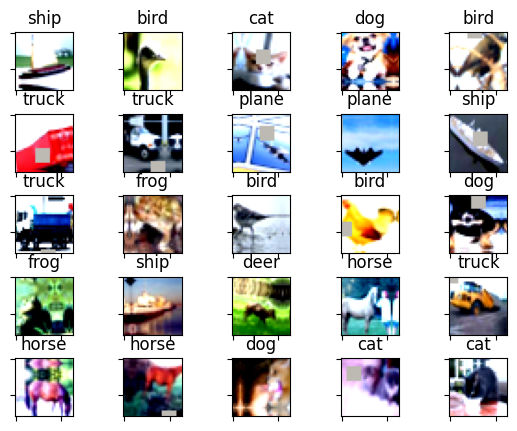

In [8]:
dataiter = iter(trainldr)
images, labels = next(dataiter)


visualize_data_loader(images, labels, classes, 5)

In [9]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
net = Net('bn').to(device)
summary(net, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.93E-02


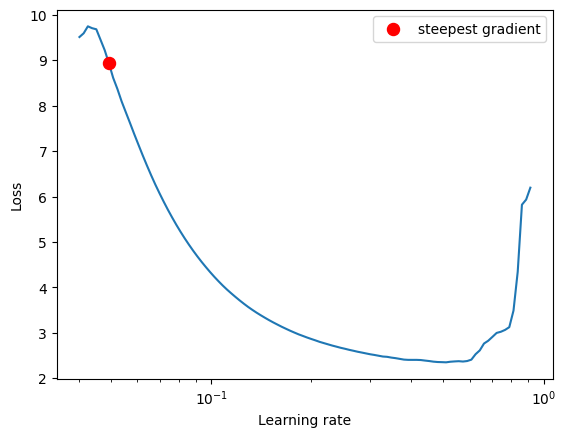

In [10]:
import torch.nn as nn
from torch_lr_finder import LRFinder
train_criterion = nn.CrossEntropyLoss()
test_criterion = nn.CrossEntropyLoss(reduction='sum')
# train_criterion = F.nll_loss
# test_criterion = F.nll_loss
optimizer = torch.optim.Adam(net.parameters(), lr=0.03, weight_decay=1e-4)
lr_finder = LRFinder(net, optimizer, train_criterion, device='cuda')
lr_finder.range_test(trainldr,end_lr=10, num_iter=200, step_mode='exp')
lr_finder.plot()
lr_finder.reset()

In [11]:
import torch
from tqdm import tqdm
from torch.optim import lr_scheduler

EPOCHS = 24

model =  Net('bn').to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr=4.93E-02,
                                    steps_per_epoch=len(trainldr),
                                    epochs=EPOCHS,
                                    pct_start=5/EPOCHS,
                                    div_factor=100,
                                    final_div_factor=100,
                                    three_phase=False,
                                    anneal_strategy='linear')


train_losses = []
test_losses = []
train_acc = []
test_acc = []



# learning_rate = []
EPOCHS = 24
for epoch in range(EPOCHS):  # loop over the dataset multiple times
    for param_group in optimizer.param_groups:
      print("lr= ",param_group['lr'])
    train_losses, train_acc = train(model, device, trainldr, optimizer, epoch, scheduler, train_criterion, train_losses, train_acc)
    test_loss, test_acc = test(model, device, testldr,test_criterion, test_losses, test_acc)
print('Finished Training')



lr=  0.000493


Epoch=1 Loss=1.3879882097244263 Batch_id=97 Accuracy=47.13: 100%|██████████| 98/98 [00:29<00:00,  3.28it/s]



Test set: Average loss: 1.5418, Accuracy: 5285/10000 (52.85%)

lr=  0.010274361963190183


Epoch=2 Loss=1.4791392087936401 Batch_id=97 Accuracy=60.86: 100%|██████████| 98/98 [00:29<00:00,  3.30it/s]



Test set: Average loss: 1.1523, Accuracy: 6516/10000 (65.16%)

lr=  0.020055723926380366


Epoch=3 Loss=0.8555753827095032 Batch_id=97 Accuracy=68.03: 100%|██████████| 98/98 [00:31<00:00,  3.14it/s]



Test set: Average loss: 1.4563, Accuracy: 6387/10000 (63.87%)

lr=  0.02983708588957055


Epoch=4 Loss=0.7122513055801392 Batch_id=97 Accuracy=73.59: 100%|██████████| 98/98 [00:32<00:00,  3.00it/s]



Test set: Average loss: 1.0196, Accuracy: 6771/10000 (67.71%)

lr=  0.03961844785276073


Epoch=5 Loss=0.6478704810142517 Batch_id=97 Accuracy=76.04: 100%|██████████| 98/98 [00:31<00:00,  3.11it/s]



Test set: Average loss: 0.9312, Accuracy: 7166/10000 (71.66%)

lr=  0.04927352574113856


Epoch=6 Loss=0.6376996040344238 Batch_id=97 Accuracy=78.25: 100%|██████████| 98/98 [00:30<00:00,  3.20it/s]



Test set: Average loss: 0.7050, Accuracy: 7838/10000 (78.38%)

lr=  0.0466790483727175


Epoch=7 Loss=0.49587711691856384 Batch_id=97 Accuracy=80.41: 100%|██████████| 98/98 [00:30<00:00,  3.18it/s]



Test set: Average loss: 0.5002, Accuracy: 8344/10000 (83.44%)

lr=  0.044084571004296455


Epoch=8 Loss=0.5350170731544495 Batch_id=97 Accuracy=82.17: 100%|██████████| 98/98 [00:31<00:00,  3.12it/s]



Test set: Average loss: 0.4509, Accuracy: 8537/10000 (85.37%)

lr=  0.0414900936358754


Epoch=9 Loss=0.4668271541595459 Batch_id=97 Accuracy=84.08: 100%|██████████| 98/98 [00:32<00:00,  3.02it/s]



Test set: Average loss: 0.4677, Accuracy: 8439/10000 (84.39%)

lr=  0.038895616267454344


Epoch=10 Loss=0.32989102602005005 Batch_id=97 Accuracy=85.11: 100%|██████████| 98/98 [00:31<00:00,  3.07it/s]



Test set: Average loss: 0.3651, Accuracy: 8780/10000 (87.80%)

lr=  0.036301138899033296


Epoch=11 Loss=0.4602336287498474 Batch_id=97 Accuracy=86.13: 100%|██████████| 98/98 [00:31<00:00,  3.07it/s]



Test set: Average loss: 0.4348, Accuracy: 8643/10000 (86.43%)

lr=  0.03370666153061224


Epoch=12 Loss=0.4356999695301056 Batch_id=97 Accuracy=86.57: 100%|██████████| 98/98 [00:30<00:00,  3.18it/s]



Test set: Average loss: 0.3610, Accuracy: 8789/10000 (87.89%)

lr=  0.03111218416219119


Epoch=13 Loss=0.4436255991458893 Batch_id=97 Accuracy=87.87: 100%|██████████| 98/98 [00:30<00:00,  3.18it/s]



Test set: Average loss: 0.3983, Accuracy: 8742/10000 (87.42%)

lr=  0.028517706793770137


Epoch=14 Loss=0.347480833530426 Batch_id=97 Accuracy=88.52: 100%|██████████| 98/98 [00:30<00:00,  3.21it/s]



Test set: Average loss: 0.3537, Accuracy: 8872/10000 (88.72%)

lr=  0.025923229425349085


Epoch=15 Loss=0.2737081050872803 Batch_id=97 Accuracy=89.41: 100%|██████████| 98/98 [00:30<00:00,  3.20it/s]



Test set: Average loss: 0.3796, Accuracy: 8828/10000 (88.28%)

lr=  0.023328752056928033


Epoch=16 Loss=0.3374912738800049 Batch_id=97 Accuracy=90.10: 100%|██████████| 98/98 [00:32<00:00,  3.04it/s]



Test set: Average loss: 0.3395, Accuracy: 8938/10000 (89.38%)

lr=  0.020734274688506985


Epoch=17 Loss=0.3155640661716461 Batch_id=97 Accuracy=90.94: 100%|██████████| 98/98 [00:30<00:00,  3.16it/s]



Test set: Average loss: 0.3352, Accuracy: 8980/10000 (89.80%)

lr=  0.01813979732008593


Epoch=18 Loss=0.26538383960723877 Batch_id=97 Accuracy=91.23: 100%|██████████| 98/98 [00:31<00:00,  3.14it/s]



Test set: Average loss: 0.2940, Accuracy: 9067/10000 (90.67%)

lr=  0.015545319951664874


Epoch=19 Loss=0.3526250123977661 Batch_id=97 Accuracy=92.33: 100%|██████████| 98/98 [00:31<00:00,  3.16it/s]



Test set: Average loss: 0.3039, Accuracy: 9083/10000 (90.83%)

lr=  0.012950842583243825


Epoch=20 Loss=0.2836291193962097 Batch_id=97 Accuracy=92.98: 100%|██████████| 98/98 [00:31<00:00,  3.09it/s]



Test set: Average loss: 0.2871, Accuracy: 9129/10000 (91.29%)

lr=  0.01035636521482277


Epoch=21 Loss=0.16996793448925018 Batch_id=97 Accuracy=93.70: 100%|██████████| 98/98 [00:30<00:00,  3.23it/s]



Test set: Average loss: 0.2677, Accuracy: 9182/10000 (91.82%)

lr=  0.007761887846401722


Epoch=22 Loss=0.15089106559753418 Batch_id=97 Accuracy=94.33: 100%|██████████| 98/98 [00:35<00:00,  2.79it/s]



Test set: Average loss: 0.2495, Accuracy: 9230/10000 (92.30%)

lr=  0.005167410477980666


Epoch=23 Loss=0.1263561248779297 Batch_id=97 Accuracy=94.94: 100%|██████████| 98/98 [00:31<00:00,  3.11it/s]



Test set: Average loss: 0.2446, Accuracy: 9266/10000 (92.66%)

lr=  0.002572933109559611


Epoch=24 Loss=0.13160082697868347 Batch_id=97 Accuracy=95.37: 100%|██████████| 98/98 [00:32<00:00,  3.05it/s]



Test set: Average loss: 0.2392, Accuracy: 9278/10000 (92.78%)

Finished Training


In [12]:
! pip install -q torchview
! pip install -q -U graphviz

In [13]:

from torchview import draw_graph
from torchvision.models import resnet18, GoogLeNet, densenet, vit_b_16
import graphviz
# when running on VSCode run the below command
# svg format on vscode does not give desired result
graphviz.set_jupyter_format('png')

'svg'

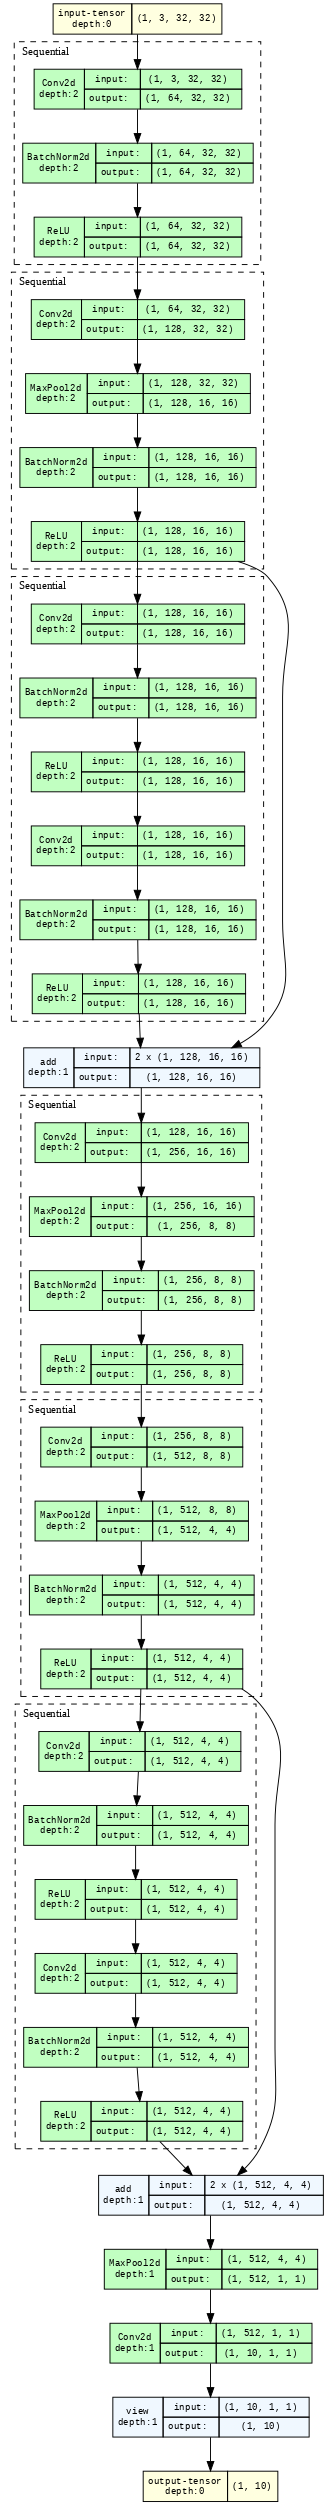

In [14]:
from torchview import draw_graph
# model = Net()
# batch_size = 2
# # device='meta' -> no memory is consumed for visualization
# model_graph = draw_graph(model, input_size=(3, 32, 32), device='meta')
model_graph1 = draw_graph(Net('bn'), input_size=(1,3,32,32), expand_nested=True, graph_dir = 'TB')
model_graph1.visual_graph